# Loading the dataset from Kaggle

In [4]:
import kagglehub
path = kagglehub.dataset_download("arjuntejaswi/plant-village")

100%|██████████| 329M/329M [00:15<00:00, 22.1MB/s]

Extracting files...


In [5]:
import os

for item in os.listdir(path):
    print(item)


PlantVillage


In [6]:
PlantVillage = os.path.join(path, "PlantVillage")

for item in os.listdir(PlantVillage):
    print(item)


Pepper__bell___healthy
Pepper__bell___Bacterial_spot
Potato___Early_blight
Tomato_Septoria_leaf_spot
Tomato_Leaf_Mold
Tomato__Target_Spot
Tomato_Spider_mites_Two_spotted_spider_mite
Potato___healthy
Tomato__Tomato_mosaic_virus
Tomato_Late_blight
Potato___Late_blight
Tomato_Early_blight
Tomato_healthy
Tomato_Bacterial_spot
Tomato__Tomato_YellowLeaf__Curl_Virus


# Importing the dependencies

In [7]:
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers



# Making the dataset ready

In [8]:
BATCH_SIZE = 32 #we used the mini gradient decent
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [9]:
plant_dir = os.path.join(path, "PlantVillage")
  # kagglehub dataset path
potato_dir = "/content/potato_only"

if os.path.exists(potato_dir):
    shutil.rmtree(potato_dir)

os.makedirs(potato_dir, exist_ok=True)

potato_folders = [
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy"
]

for folder in potato_folders:
    shutil.copytree(
        os.path.join(plant_dir, folder),
        os.path.join(potato_dir, folder)
    )

print(os.listdir(potato_dir))


['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']


In [10]:
dataset = tf.keras.utils.image_dataset_from_directory(
    potato_dir,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(dataset.class_names)


Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0]


In [12]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [13]:
len(dataset)

68

In [14]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


# Visualizing image

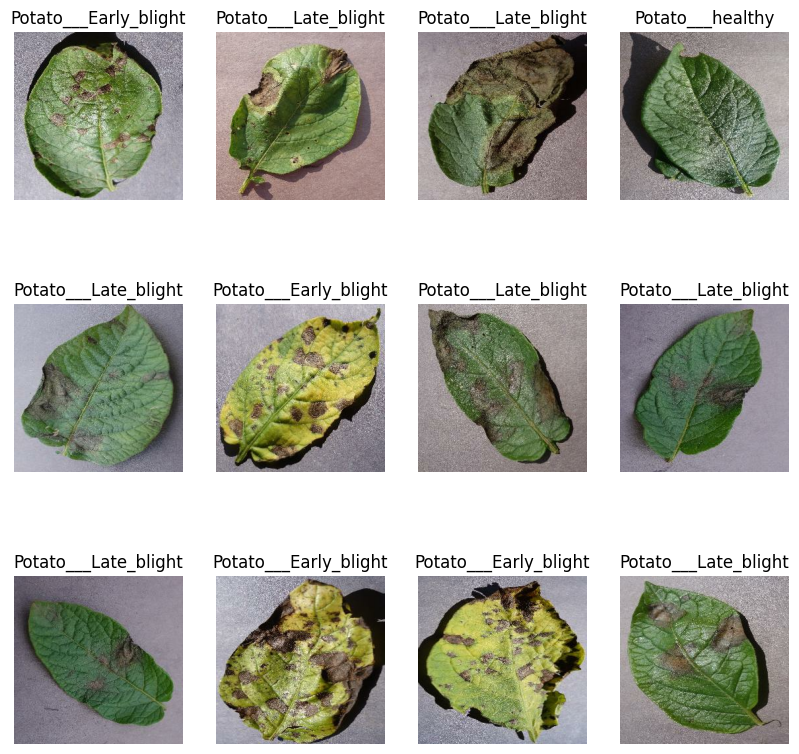

In [16]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Split dataset for trainging

In [17]:
# 80% ==> trianing
# 20% ==>10% validation , 10% test

SyntaxError: invalid syntax (ipython-input-2591022274.py, line 1)

In [18]:
len(dataset)

68

In [19]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [20]:
train_ds = dataset.take(54)
len(train_ds)

54

In [21]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [25]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [26]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [27]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [28]:
#using python
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
len(train_ds)

54

In [31]:
len(val_ds)

6

In [32]:
len(test_ds)

8

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [34]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation  = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation = "softmax"),
])
model.build(input_shape = input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 3)                │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,875 (655.76 KB)

 Trainable params: 167,875 (655.76 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [39]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.4990 - loss: 0.9234 - val_accuracy: 0.5000 - val_loss: 0.9438
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6423 - loss: 0.7492 - val_accuracy: 0.7865 - val_loss: 0.4482
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8450 - loss: 0.3729 - val_accuracy: 0.8750 - val_loss: 0.3183
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8755 - loss: 0.2927 - val_accuracy: 0.8646 - val_loss: 0.3315
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8984 - loss: 0.2489 - val_accuracy: 0.8750 - val_loss: 0.2858
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9073 - loss: 0.2512 - val_accuracy: 0.9167 - val_loss: 0.2027
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9442 - loss: 0.1563 - val_accuracy: 0.9479 - val_loss: 0.1309
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9274 - loss: 0.1854 - val_accuracy: 0.9271 -

In [40]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9893 - loss: 0.0242


[0.021011507138609886, 0.9921875]

In [44]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9882 - loss: 0.0339


In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [49]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

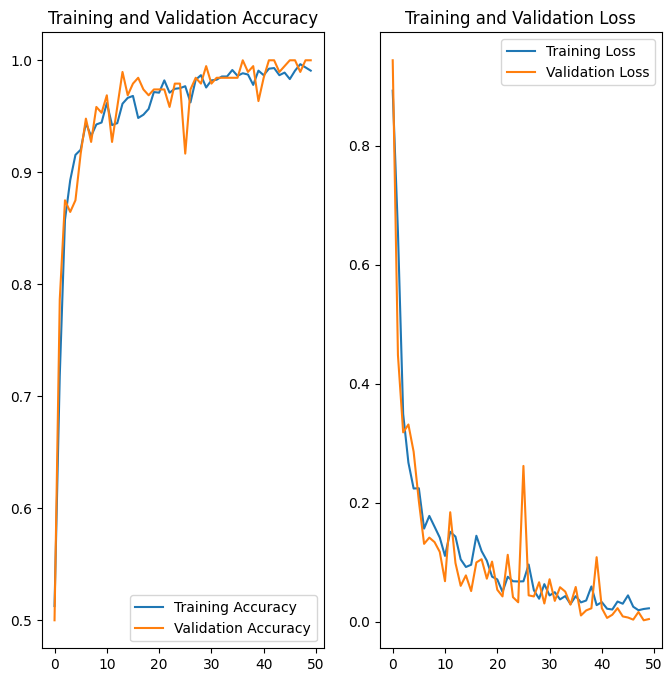

In [52]:
from re import L
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[6.5681342e-13 9.9999988e-01 1.0539225e-07]
predicted label: Potato___Late_blight


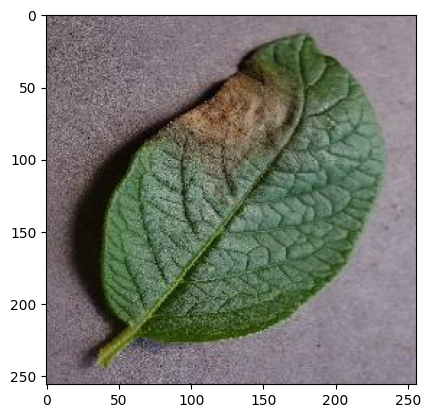

In [60]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print(batch_prediction[0])
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


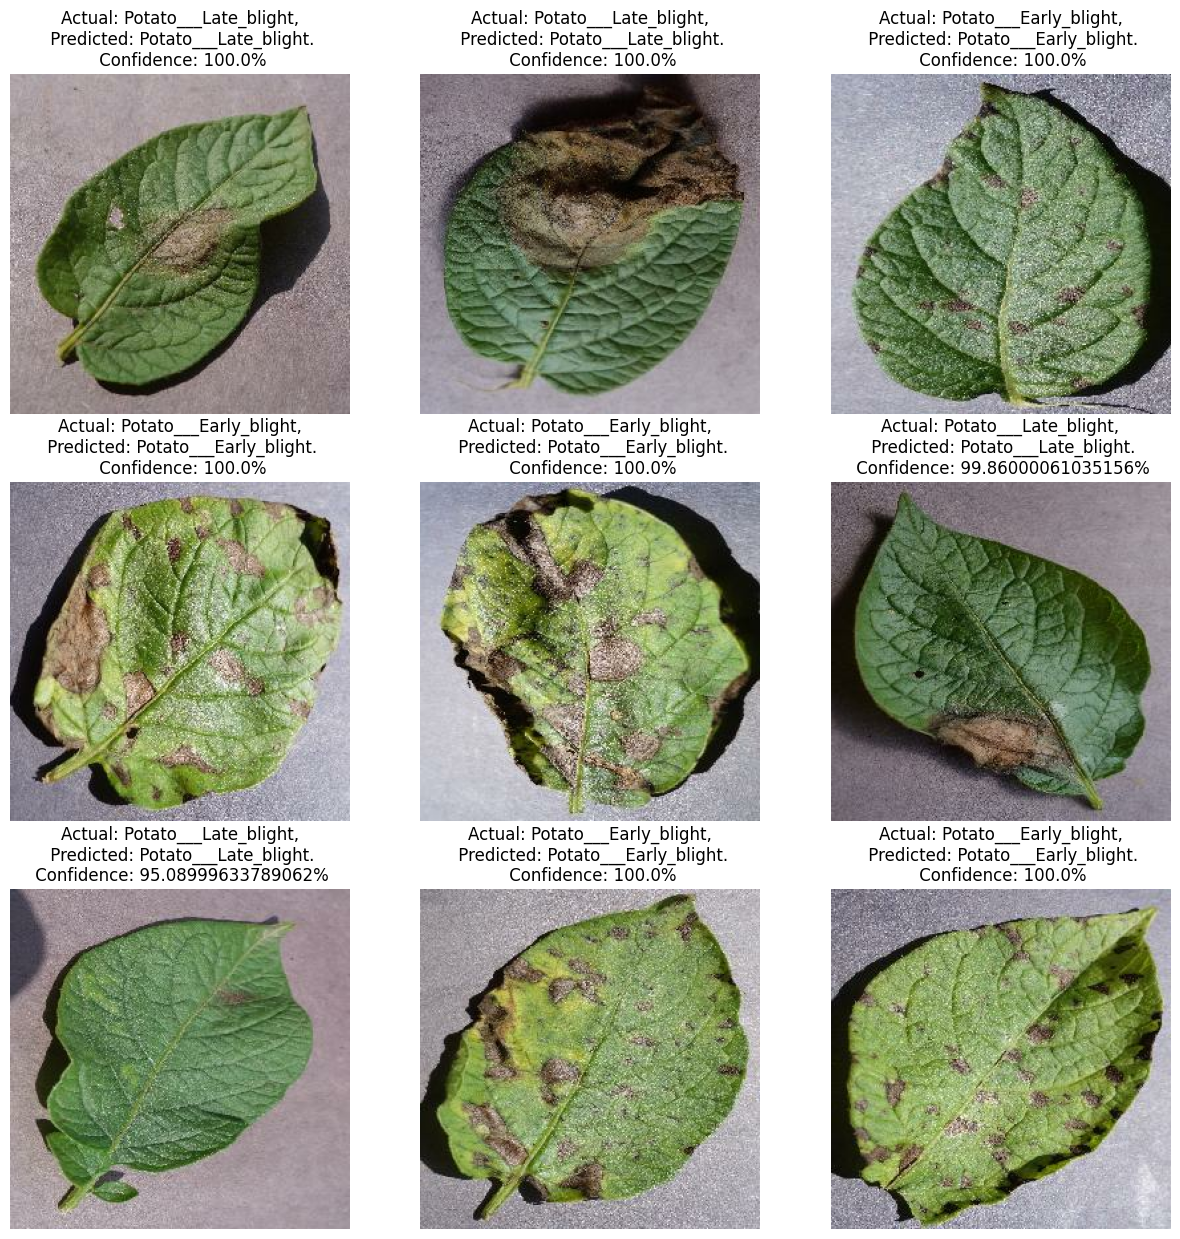

In [63]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")

# Saving the model

In [70]:
os.listdir("../model")
model_version = max([int(i) for i in os.listdir("../model") + [0] ]) +1
model_version

In [68]:
model.save(f"../model/{model_version}")
